In [14]:
import tensorflow.compat.v1 as tf
from tensorflow.python.framework import ops
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tf_utils import random_mini_batches, forward_propagation_for_predict

%matplotlib inline
tf.disable_v2_behavior()
tf.reset_default_graph()

In [15]:
data = pd.read_csv('../datasets/year_prediction.csv').to_numpy()

In [ ]:
X_train_orig = data[0:463715, 1:91].T
Y_train = data[0:463715, 0].reshape(-1, 1).T
X_test_orig = data[463715:, 1:91].T
Y_test = data[463715:, 0].reshape(-1, 1).T

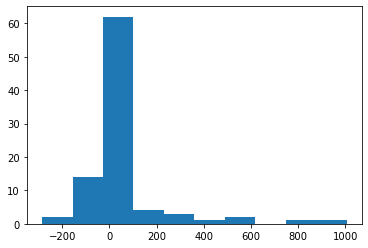

In [ ]:
attribute = 5
plt.hist(X_train_orig[:, attribute])
plt.show()

In [ ]:
# Normalize data
means = np.mean(X_train_orig, axis=1)
stds = np.std(X_train_orig, axis=1)
X_train = np.zeros(X_train_orig.shape)
X_test = np.zeros(X_test_orig.shape)

for i in range(X_train_orig.shape[0]):
   X_train[i, :] = (X_train_orig[i, :] - means[i]) / stds[i]
   X_test[i:, ] = (X_test_orig[i, :] - means[i]) / stds[i]

In [ ]:
def create_placeholder(n_x, n_y):
    X = tf.placeholder(tf.float32, [n_x, None])
    Y = tf.placeholder(tf.float32, [n_y, None])
    return X, Y

In [ ]:
def initialize_parameters(lambd):
    L2 = tf.keras.regularizers.l2(lambd)
    W1 = tf.get_variable("W1", [25, 90], initializer=tf.initializers.he_normal(), regularizer=L2)
    b1 = tf.get_variable("b1", [25, 1], initializer=tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer=tf.initializers.he_normal(), regularizer=L2)
    b2 = tf.get_variable("b2", [12, 1], initializer=tf.zeros_initializer())
    W3 = tf.get_variable("W3", [1, 12], initializer=tf.initializers.he_normal(), regularizer=L2)
    b3 = tf.get_variable("b3", [1, 1], initializer=tf.zeros_initializer())
    parameters = {
        "W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3
    }
    return parameters


In [ ]:
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]

    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    return Z3

In [ ]:
def compute_cost(Z3, Y, lambd):
    predictions = tf.transpose(Z3)
    target = tf.transpose(Y)
    cost = tf.reduce_mean(tf.square(target - predictions))
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    reg_cost = cost + lambd * sum(reg_losses)
    return reg_cost

In [ ]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001, lambd=0.01,
        num_epochs=1500, minibatch_size=128, print_cost=True):
    ops.reset_default_graph()
    seed = 3
    (n_x, _) = X_train.shape
    n_y = Y_train.shape[0]
    costs = []

    X, Y = create_placeholder(n_x, n_y)
    parameters = initialize_parameters(lambd)
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y, lambd)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0.
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / minibatch_size
            if print_cost and epoch % 10 == 0:
                print("Cost after epoch %i: %f" %(epoch, epoch_cost))
            if print_cost:
                costs.append(epoch_cost)

        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title('Learning rate = ' + str(learning_rate))
        plt.show()

        parameters = sess.run(parameters)
        RMSE = tf.reduce_mean(tf.square(Y - Z3))
        print("Test mean squared error:", RMSE.eval(feed_dict={X: X_test, Y: Y_test}))

        return parameters


In [ ]:
parameters = model(X_train, Y_train, X_test, Y_test, learning_rate=0.01, num_epochs=100, minibatch_size=32768)

AttributeError: module 'tensorflow.python.keras.api._v1.keras.regularizers' has no attribute 'L2'

In [ ]:
def predict(X, parameters):
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [90, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    
    sess = tf.Session()
    prediction = sess.run(z3, feed_dict = {x: X})
        
    return int(np.round(np.squeeze(prediction)))

In [ ]:
my_song_idx = np.random.randint(0, X_test.shape[1])
my_song = X_test[:, my_song_idx].reshape(-1, 1)
my_image_prediction = predict(my_song, parameters)
print("Your algorithm predicts: y = " + str(my_image_prediction))
print("The actual y value: " + str(int((np.squeeze(Y_test[:, my_song_idx])))))

Your algorithm predicts: y = 2000
The actual y value: 2007
